How does the velocity compare for observations made on opposite sides of the galaxy?

In [1]:
from astropy.table import Table
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy.io import fits
from astropy import units as u

import numpy as np

import matplotlib.pyplot as plt

In [2]:
h = 1
H0 = 100*h

c = 3e5

q0 = 0.2

# V0 = 2.5  <-- V0 is now computed from the galaxies in the final calibration sample

# Data

In [3]:
tfuji = Table.read('/global/cfs/projectdirs/desi/science/td/pv/desi_pv_tf_fuji_healpix.fits')
tfuji[:5]

TARGETID,TARGET_RA,TARGET_DEC,HEALPIX,SURVEY,Z,ZERR,ZWARN,DELTACHI2,FILENAME,PVTYPE,SGA_ID,RA,DEC
int64,float64,float64,int64,bytes3,float64,float64,int64,float64,bytes63,bytes3,int64,float64,float64
1079550234591232,194.390863195343,27.5157211790145,10378,sv3,1.1235686466514,7.31685779475115e-05,4,3.28414569795132,fuji/healpix/sv3/bright/103/10378/redrock-sv3-bright-10378.fits,EXT,662902,194.39086319534337,27.51572117901454
1092744374124544,194.390863195343,27.5157211790145,10378,sv3,0.686773088332363,6.9756676262104e-05,4,0.786607094109058,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.39086319534337,27.51572117901454
1092744374124546,194.364461113654,27.5037185881314,10378,sv3,0.0242933923052181,4.95233472646785e-05,0,95.428411073226,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.36446111365385,27.50371858813136
1092744369930240,194.338458724402,27.4918902690326,10378,sv3,0.0264170223697961,0.00010139452689994,0,9.53278421035066,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.33845872440244,27.491890269032595
1092744374124545,194.377858465028,27.5098100780282,10378,sv3,0.211332646769145,6.68535116703737e-05,4,3.73989077657461,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.3778584650283,27.509810078028195


In [4]:
SGA = Table.read('/global/cfs/cdirs/cosmo/data/sga/2020/SGA-2020.fits', 'ELLIPSE')
SGA[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32
2,SGA-2020 2,PGC1283207,1283207,228.3770865,5.4232017,S?,152.2,0.36307806,0.724436,0.03463229,23.40448,16.976,False,LEDA-20181114,0,PGC1283207,1,True,228.3770865,5.4232017,0.36307806,2283p055,228.3770803831908,5.423191398593787,0.49470574,SB26,158.20142,0.545691,228.37700918822188,5.4232652570544015,10.897086,3.3509698,3.1147978,3.240862,5.902337,6.9126143,7.941369,8.997992,10.073601,11.199986,12.391357,13.561038,14.841172,16.966799,16.108246,15.486356,16.879545,16.024958,15.400715,16.818878,15.967034,15.341793,16.776297,15.925804,15.300776,16.746685,15.897334,15.272053,16.725166,15.876816,15.2521105,16.708357,15.862035,15.237181,16.696539,15.851936,15.226998,16.689613,15.844313,15.21976,0.013392451,0.02354,0.021872982,0.01736985,0.024445537,0.039866067,0.05026544,0.08455789,0.122911856,0.005682776,0.0054258136,0.0049038026,0.005588406,0.005323561,0.0047632363,0.00543534,0.005177031,0.0046343105,0.0053025587,0.005040888,0.0045181247,0.005206092,0.0049438984,0.0044374703,0.0051483097,0.0048758644,0.0043834248,0.0051032505,0.0048264163,0.004344248,0.0050705094,0.004792021,0.004319857,0.005054293,0.004765629,0.0043044444,16.65942,0.34037337,0.2978292,3.0239506,0.07928849,15.820566,0.2640441,0.34559453,3.3033552,0.003811298,15.195567,0.29826432,0.3001073,3.2333765,0.011723555,0
3,SGA-2020 3,PGC1310416,1310416,202.54443750000002,6.9345944,Sc,159.26,0.4017908,0.7816278,0.073888786,23.498482,16.85,False,LEDA-20181114,1,PGC1310416,1,True,202.54443750000002,6.9345944,0.4017908,

In [5]:
SGA_dict = {}

for i in range(len(SGA)):
    
    SGA_dict[SGA['SGA_ID'][i]] = i

## Separate the fuji data into center and off-center observations

In [6]:
tfuji['SKY_FIBER_DIST'] = 0.
tfuji['SKY_FIBER_DIST_R26'] = 0.

# For each SGA galaxy that has at least one observation, calculate the distance 
# for all of that galaxy's targets
for sga_id in np.unique(tfuji['SGA_ID']):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = tfuji['SGA_ID'] == sga_id
    
    # Find galaxy index in SGA catalog
    sga_idx = SGA_dict[sga_id]
    
    #---------------------------------------------------------------------------
    # Calculate distance between each observation and the center of the SGA 
    # galaxy
    #---------------------------------------------------------------------------
    SGA_coords = SkyCoord(ra=SGA['RA'][sga_idx], 
                          dec=SGA['DEC'][sga_idx], 
                          unit=u.degree)
    target_coords = SkyCoord(ra=tfuji['RA'][obs_idx], 
                             dec=tfuji['DEC'][obs_idx], 
                             unit=u.degree)
    
    sep2d = target_coords.separation(SGA_coords)
    
    tfuji['SKY_FIBER_DIST'][obs_idx] = sep2d
    tfuji['SKY_FIBER_DIST_R26'][obs_idx] = 2*sep2d.to('arcmin')/(SGA['D26'][sga_idx]*u.arcmin)
    #---------------------------------------------------------------------------

In [7]:
centers_boolean = tfuji['SKY_FIBER_DIST_R26'] < 0.1

fuji_centers = tfuji[centers_boolean]
fuji_axis = tfuji[~centers_boolean]

## Clean the fuji center observations

Only keep those with
* `DELTACHI2` > 25
* `ZWARN` == 0

In [8]:
good_centers = fuji_centers[(fuji_centers['DELTACHI2'] > 25) & (fuji_centers['ZWARN'] == 0)]

## If an SGA galaxy has at least one observation at its center, set the redshift of that galaxy

In [9]:
SGA['Z_DESI'] = np.nan
SGA['ZERR_DESI'] = np.nan

weights = 1./(good_centers['ZERR']**2)

n = 0

delta_z = np.array([])

for sga_id in np.unique(good_centers['SGA_ID']):
    
    # Find all the center observations of this galaxy
    obs_idx = good_centers['SGA_ID'] == sga_id
    
    # Find the row in the SGA for this galaxy
    SGA_idx = SGA_dict[sga_id]
    
    # Set the redshift of this galaxy to be the weighted average redshift of all 
    # good center observations
    SGA['Z_DESI'][SGA_idx] = np.average(good_centers['Z'][obs_idx], 
                                        weights=weights[obs_idx])
    SGA['ZERR_DESI'][SGA_idx] = np.sqrt(1./np.sum(weights[obs_idx]))
    
    n_obs = np.sum(obs_idx)
    
    # If there is more than one center observation, plot the difference in redshift between the two
    if n_obs > 1:
        
        diff_matrix = good_centers['Z'][obs_idx].reshape(n_obs,1) - good_centers['Z'][obs_idx].reshape(1,n_obs)
            
        diffs = diff_matrix[np.triu_indices(n_obs, k=1)]
            
        delta_z = np.append(delta_z, diffs)
            
        if np.any(np.abs(diffs*c) > 50.):

            print(sga_id)
            print(c*diffs)
            print(good_centers[['TARGETID', 'Z', 'PVTYPE', 'FILENAME', 'SKY_FIBER_DIST_R26', 'RA', 'DEC']][good_centers['SGA_ID'] == sga_id].pprint(max_width=-1))
        
        n += 1
        
print(n)

1244275
[ 64.28076017  31.31517601 -32.96558415]
      TARGETID              Z          PVTYPE                             FILENAME                            SKY_FIBER_DIST_R26         RA                DEC        
------------------- ------------------ ------ --------------------------------------------------------------- ------------------ ------------------ ------------------
  39627751505793346 0.0355092755654211    TFT fuji/healpix/sv1/bright/255/25596/redrock-sv1-bright-25596.fits                0.0 179.96134623597172 -1.381875734504479
2305843036053047801 0.0352950063648648    TFT fuji/healpix/sv3/backup/255/25596/redrock-sv3-backup-25596.fits                0.0 179.96134623597172 -1.381875734504479
  39627751505793346 0.0354048916453766    TFT fuji/healpix/sv3/bright/255/25596/redrock-sv3-bright-25596.fits                0.0 179.96134623597172 -1.381875734504479
None
175


### Plot a histogram of the difference in velocities for the good centers

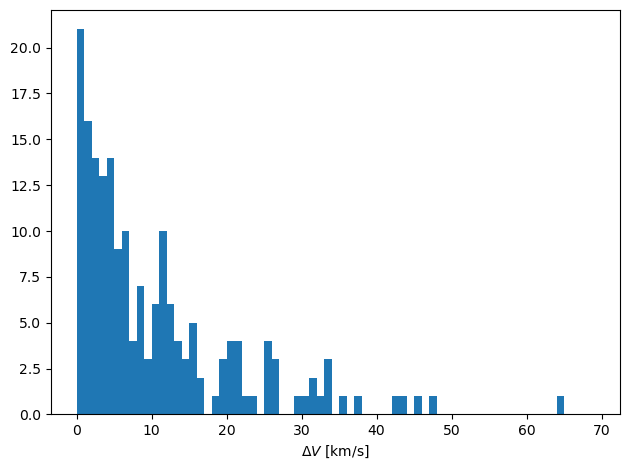

In [10]:
plt.figure(tight_layout=True)

plt.hist(np.abs(delta_z*c), bins=np.arange(0,70,1))

plt.xlabel('$\Delta V$ [km/s]');

All of the positions of these observations look good.  The two largest ones show a slight offset from the center of the galaxy (although still well close to the center of the nucleus).  However, their ($\alpha$, $\delta$) coordinates are identical, so we can't determine which is "more centered."

# Calculate the rotational velocities

In [11]:
fuji_axis['V_ROT'] = np.nan
fuji_axis['V_ROT_ERR'] = np.nan

# For each SGA galaxy that has at least one good center observation, calculate 
# the rotational velocity for all of that galaxy's targets
for sga_id in np.unique(good_centers['SGA_ID']):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = fuji_axis['SGA_ID'] == sga_id
    
    # Find galaxy index in SGA catalog
    sga_idx = SGA_dict[sga_id]
    
    #---------------------------------------------------------------------------
    # Calculate rotational velocity
    #---------------------------------------------------------------------------
    # Use the average redshift of all of the center observations for the 
    # systemic velocity
    z_center = SGA['Z_DESI'][sga_idx]
    z_err_center2 = SGA['ZERR_DESI'][sga_idx]**2
    
    # Calculate the rotational velocity for all observations of the galaxy
    fuji_axis['V_ROT'][obs_idx] = c*(fuji_axis['Z'][obs_idx] - z_center)
    fuji_axis['V_ROT_ERR'][obs_idx] = c*np.sqrt(fuji_axis['ZERR'][obs_idx]**2 + z_err_center2)
    #---------------------------------------------------------------------------
    
    
    #---------------------------------------------------------------------------
    # Correct rotational velocities for inclination angle
    #---------------------------------------------------------------------------
    cosi2 = (SGA['BA'][sga_idx]**2 - q0**2)/(1 - q0**2)
    
    # Galaxies with b/a < q0
    if cosi2 < 0:
        cosi2 = 0.
        
    fuji_axis['V_ROT'][obs_idx] /= np.sin(np.arccos(np.sqrt(cosi2)))
    #---------------------------------------------------------------------------

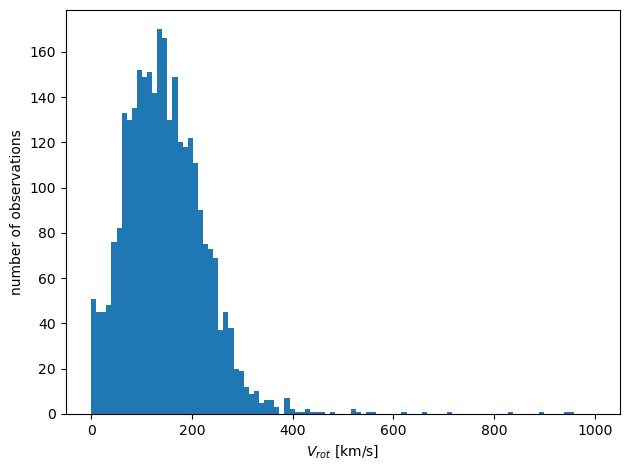

In [12]:
plt.figure(tight_layout=True)

plt.hist(np.abs(fuji_axis['V_ROT']), bins=np.linspace(0, 1000, 100))

plt.xlabel('$V_{rot}$ [km/s]')
plt.ylabel('number of observations');

# Cut for galaxies suitable for the TFR

Requirements:
* $10 < V_{rot} < 1000$ km/s at $0.33R_{26}$

## Velocity cut

In [13]:
r0p3 = (fuji_axis['SKY_FIBER_DIST_R26'] > 0.3) & (fuji_axis['SKY_FIBER_DIST_R26'] < 0.4)

Vgood = (np.abs(fuji_axis['V_ROT']) < 1000) & (np.abs(fuji_axis['V_ROT']) >= 10)

good_axis = fuji_axis[r0p3 & Vgood]

print(len(good_axis), len(np.unique(good_axis['SGA_ID'])))

2334 1205


In [28]:
good_axis.write('fuji_

['TARGETID',
 'TARGET_RA',
 'TARGET_DEC',
 'HEALPIX',
 'SURVEY',
 'Z',
 'ZERR',
 'ZWARN',
 'DELTACHI2',
 'FILENAME',
 'PVTYPE',
 'SGA_ID',
 'RA',
 'DEC',
 'SKY_FIBER_DIST',
 'SKY_FIBER_DIST_R26',
 'V_ROT',
 'V_ROT_ERR']

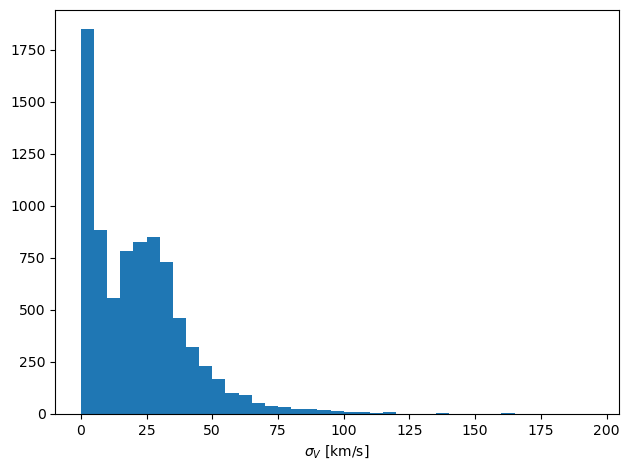

In [33]:
plt.figure(tight_layout=True)

plt.hist(fuji_axis['V_ROT_ERR'], bins=np.arange(0,200,5))

plt.xlabel('$\sigma_V$ [km/s]');

In [43]:
fuji_axis[['ZWARN', 'DELTACHI2', 'ZERR', 'V_ROT_ERR']][fuji_axis['ZERR'] < 1e-10].show_in_notebook()
# np.unique(fuji_axis['ZWARN'][fuji_axis['ZERR'] < 1e-10])

idx,ZWARN,DELTACHI2,ZERR,V_ROT_ERR
0,1570,1.94266889222573e+84,4.13114935733491e-48,nan
1,1570,1.94266889222573e+84,4.13114935733491e-48,nan
2,1570,1.94266889222573e+84,4.13114935733491e-48,1.258505304313815
3,1570,1.94266889222573e+84,4.13114935733491e-48,0.1563368426626227
4,1570,1.94266889222573e+84,4.13114935733491e-48,2.4668342935071
5,1570,1.94266889222573e+84,4.13114935733491e-48,2.4668342935071
6,1570,1.94266889222573e+84,4.13114935733491e-48,5.99861314884249
7,1570,1.94266889222573e+84,4.13114935733491e-48,2.3991707786724
8,1570,1.94266889222573e+84,4.13114935733491e-48,nan
9,1570,1.94266889222573e+84,4.13114935733491e-48,2.4752231330399126


### How do the velocities compare for objects that have multiple observations?

Also, keep track of those which would get cut by our $\Delta V / V_\text{min} < 5$ requirement. 

In [14]:
n = 0

delta_v = np.array([])
delta_v_norm_min = np.array([])
delta_v_norm_sigma = np.array([])
deltachi2 = np.array([])
v_norm_min = np.array([])
v_norm_max = np.array([])

good_deltaVs = np.array([])
good_deltaV_norm_sigma = np.array([])

deltachi2_idx = good_axis['DELTACHI2'] >= 25

for sga_id in np.unique(good_axis['SGA_ID']):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = good_axis['SGA_ID'] == sga_id
    
    n_obs = np.sum(obs_idx)
    
    if n_obs > 1:
        
        v_min = np.min(np.abs(good_axis['V_ROT'][obs_idx]))
        v_max = np.max(np.abs(good_axis['V_ROT'][obs_idx]))
        
        v_norm_min = np.append(v_norm_min, np.abs(good_axis['V_ROT'][obs_idx])/v_min)
        v_norm_max = np.append(v_norm_max, np.abs(good_axis['V_ROT'][obs_idx])/v_max)
        
        deltachi2 = np.append(deltachi2, good_axis['DELTACHI2'][obs_idx])
        
        diff_matrix = np.abs(good_axis['V_ROT'][obs_idx]).reshape(n_obs,1) - np.abs(good_axis['V_ROT'][obs_idx]).reshape(1,n_obs)
        
        sigma_matrix = np.sqrt(good_axis['V_ROT_ERR'][obs_idx].reshape(n_obs,1)**2 + good_axis['V_ROT_ERR'][obs_idx].reshape(1,n_obs)**2)
        
        diffs = diff_matrix[np.triu_indices(n_obs, k=1)]
        
        sigmas = sigma_matrix[np.triu_indices(n_obs, k=1)]
        
        diff_matrix_norm = diff_matrix/v_min
        diffs_norm = diffs/v_min
        
        diffs_norm_sigma = diffs/sigmas
            
        delta_v = np.append(delta_v, diffs)
        
        delta_v_norm_min = np.append(delta_v_norm_min, diffs_norm)
        
        delta_v_norm_sigma = np.append(delta_v_norm_sigma, diffs_norm_sigma)
        '''
        #if np.any(np.abs(diffs) > 100.):
        if np.any(np.abs(diffs_norm) > 5.):

            print(sga_id)
            print(diffs, diffs_norm)
            print(good_axis[['TARGETID', 'V_ROT', 'PVTYPE', 'FILENAME', 'DELTACHI2', 'ZWARN']][obs_idx].pprint(max_width=-1))
        '''
        
        ########################################################################
        # For Delta V / Vmin cut
        #-----------------------------------------------------------------------
        if np.any(np.abs(diff_matrix_norm) > 5):
            
            # Remove all observations with DELTACHI2 < 25
            # Note: This also typically removes observations with ZWARN != 0
            good_obs_idx = obs_idx & deltachi2_idx
            
            n_obs_good = np.sum(good_obs_idx)
            
            # Check to make sure that, if there are still multiple observations, 
            # they all satisfy our relative velocity criteria
            if n_obs_good > 1:
                
                Vmin = np.min(np.abs(good_axis['V_ROT'][good_obs_idx]))
                
                diff_matrix = np.abs(good_axis['V_ROT'][good_obs_idx]).reshape(n_obs_good, 1) - np.abs(good_axis['V_ROT'][good_obs_idx]).reshape(1, n_obs_good)
                
                diff_matrix_norm = diff_matrix/Vmin
                
                if np.all(np.abs(diff_matrix_norm) <= 5):
                    
                    sigma_matrix = np.sqrt(good_axis['V_ROT_ERR'][good_obs_idx].reshape(n_obs_good,1)**2 + good_axis['V_ROT_ERR'][good_obs_idx].reshape(1,n_obs_good)**2)
                    
                    good_deltaVs = np.append(good_deltaVs, diff_matrix[np.triu_indices(n_obs_good, k=1)])
                    good_deltaV_norm_sigma = np.append(good_deltaV_norm_sigma, 
                                                       diff_matrix[np.triu_indices(n_obs_good, k=1)]/sigma_matrix[np.triu_indices(n_obs_good, k=1)])
        else:
            good_deltaVs = np.append(good_deltaVs, diffs)
            good_deltaV_norm_sigma = np.append(good_deltaV_norm_sigma, diffs_norm_sigma)
        ########################################################################
        
        n += 1
        
print(n)

727


#### Plot a histogram of the difference in rotational velocities

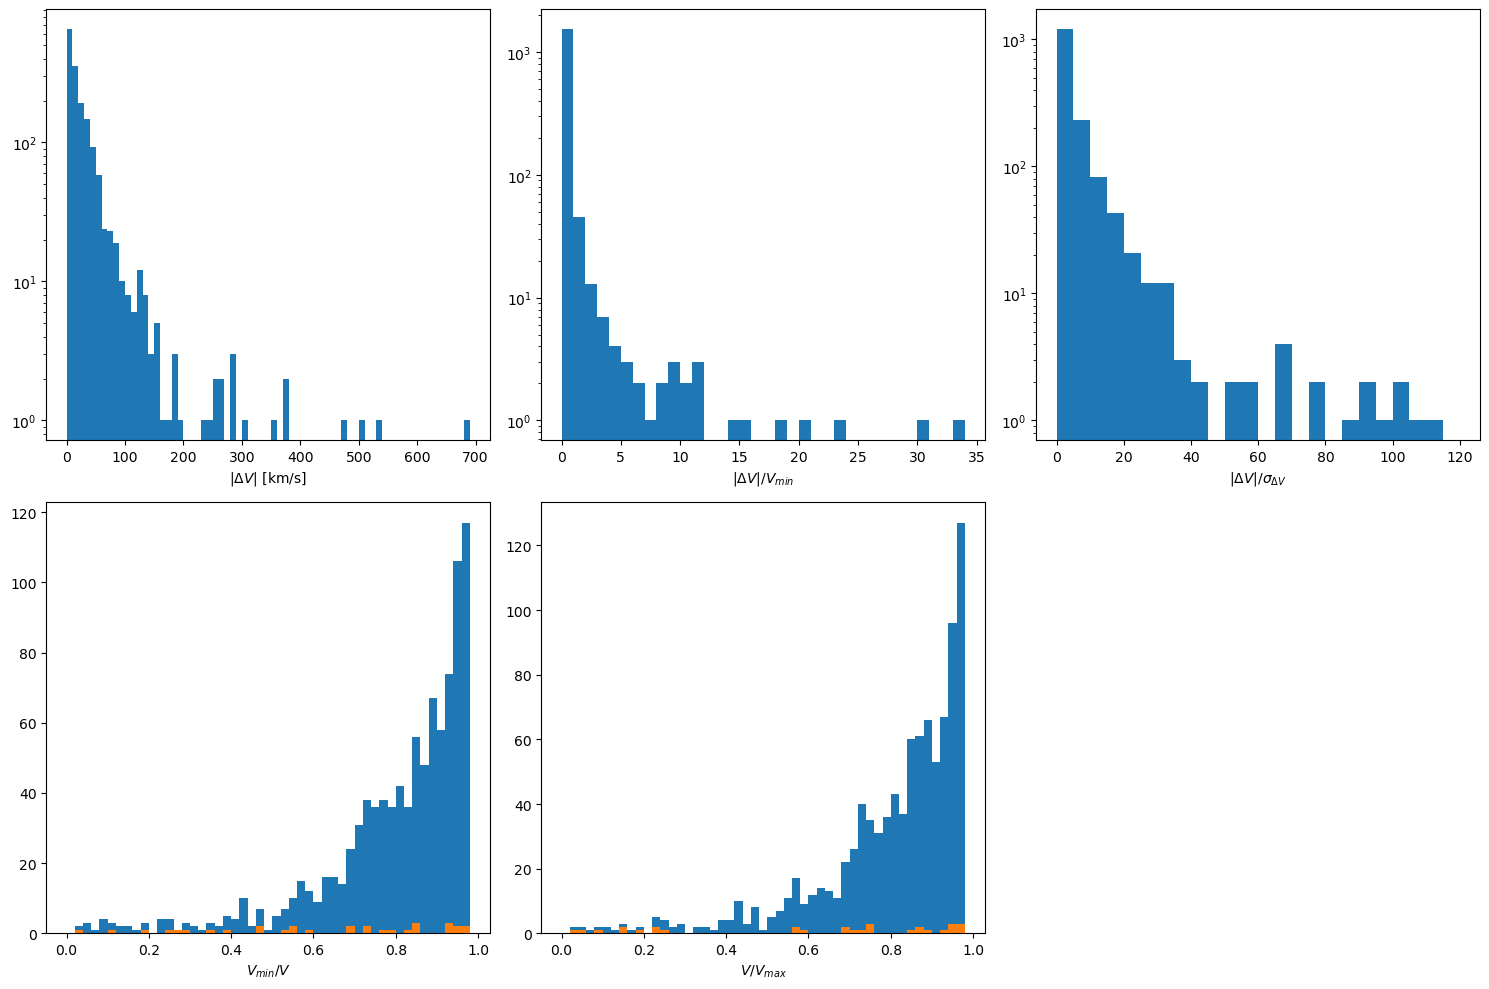

In [15]:
plt.figure(tight_layout=True, figsize=(15,10))


plt.subplot(231)

plt.hist(np.abs(delta_v), bins=np.arange(0,700,10))

plt.yscale('log')

plt.xlabel('|$\Delta V$| [km/s]')


plt.subplot(232)

plt.hist(np.abs(delta_v_norm_min), bins=np.arange(0,35,1))

plt.yscale('log')

plt.xlabel('$|\Delta V| / V_{min}$')


plt.subplot(233)

plt.hist(np.abs(delta_v_norm_sigma), bins=np.arange(0,125,5))

plt.yscale('log')

plt.xlabel('$|\Delta V| / \sigma_{\Delta V}$')


plt.subplot(234)

plt.hist(1/v_norm_min, bins=np.arange(0,1,0.02))
plt.hist(1/v_norm_min[deltachi2 < 25], bins=np.arange(0,1,0.02))

#plt.yscale('log')

plt.xlabel('$V_{min} / V$')


plt.subplot(235)

plt.hist(v_norm_max, bins=np.arange(0,1,0.02))
plt.hist(v_norm_max[deltachi2 < 25], bins=np.arange(0,1,0.02))

#plt.yscale('log')

plt.xlabel('$V / V_{max}$');

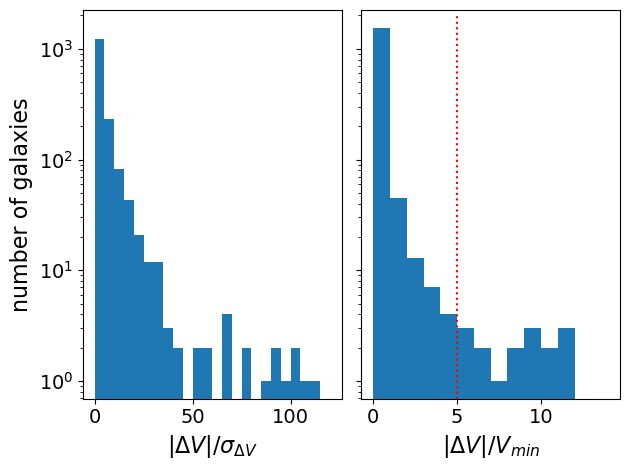

In [22]:
plt.figure(tight_layout=True)


ax1 = plt.subplot(121)
'''
plt.hist(np.abs(delta_v), bins=np.arange(0,600,20))
# plt.hist(np.abs(good_deltaVs), fill=False, hatch='x', bins=np.arange(0,600,20))
plt.xlabel('$\Delta V$ [km/s]', fontsize=16)
'''
plt.hist(np.abs(delta_v_norm_sigma), bins=np.arange(0, 125, 5))
# plt.hist(np.abs(good_deltaV_norm_sigma), fill=False, hatch='x', bins=np.arange(0, 125, 5))
plt.xlabel('$|\Delta V| / \sigma_{\Delta V}$', fontsize=16)

plt.yscale('log')
# plt.ylim([0, 1600])
plt.tick_params(axis='both', which='major', labelsize=14)
plt.ylabel('number of galaxies', fontsize=16)


ax2 = plt.subplot(122, sharey=ax1)
plt.hist(np.abs(delta_v_norm_min), bins=np.arange(0,15,1))
plt.vlines(5, 0, 2000, colors='r', linestyles='dotted')
plt.tick_params('x', which='major', labelsize=14)
plt.tick_params('y', labelleft=False)
plt.xlabel('$|\Delta V| / V_{min}$', fontsize=16);

# plt.savefig('../../Figures/SV/fuji_deltaVlog_20240619.png', dpi=150);

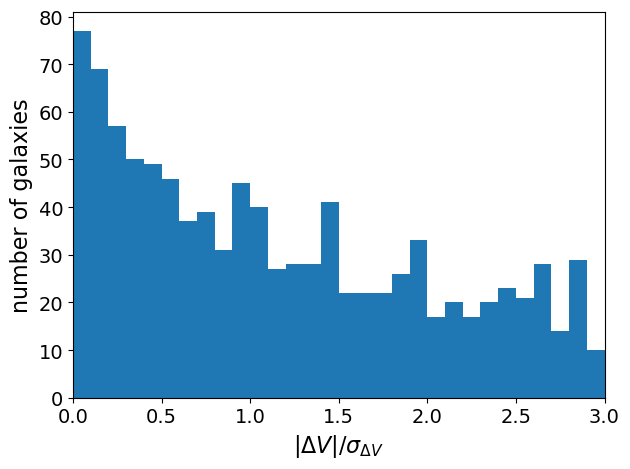

In [26]:
plt.figure(tight_layout=True)

# plt.grid()

plt.hist(np.abs(delta_v_norm_sigma), bins=np.arange(0, 125, 0.1))
plt.xlabel('$|\Delta V| / \sigma_{\Delta V}$', fontsize=16)

plt.xlim([0, 3])

plt.tick_params(axis='both', which='major', labelsize=14)
plt.ylabel('number of galaxies', fontsize=16);

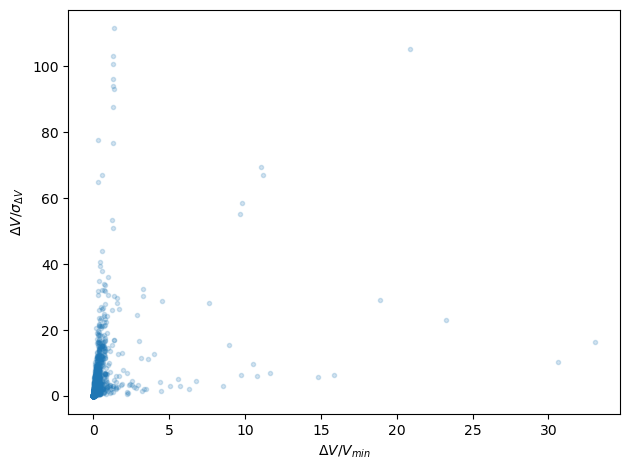

In [23]:
plt.figure(tight_layout=True)

plt.plot(np.abs(delta_v_norm_min), np.abs(delta_v_norm_sigma), '.', alpha=0.2)

plt.xlabel('$\Delta V / V_{min}$')
plt.ylabel('$\Delta V / \sigma_{\Delta V}$');

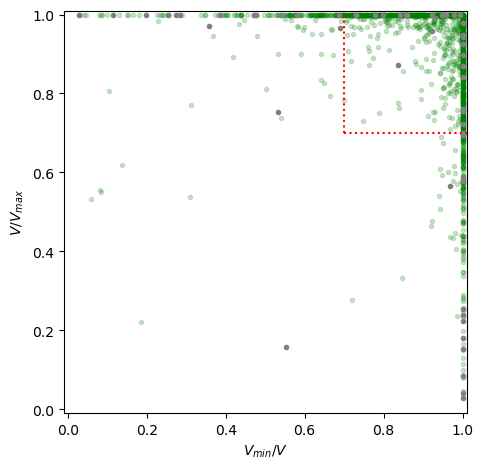

In [45]:
plt.figure(tight_layout=True)

plt.plot(1/v_norm_min[deltachi2 >= 25], v_norm_max[deltachi2 >= 25], 'g.', alpha=0.2)
plt.plot(1/v_norm_min[deltachi2 < 25], v_norm_max[deltachi2 < 25], '.', c='gray')

plt.hlines(0.7, 0.7, 1.1, colors='r', linestyles=':')
plt.vlines(0.7, 0.7, 1.1, colors='r', linestyles=':')

plt.gca().set_aspect('equal', 'box')

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])

plt.xlabel('$V_{min} / V$')
plt.ylabel('$V / V_{max}$');